In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
import re
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math

warnings.filterwarnings('ignore')

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## 0. 데이터 불러오기

In [2]:
user_info = pd.read_csv("../../data/glowpick_user_info_new.csv")

del user_info["Unnamed: 0"]

## 1. 리뷰어 세분화

### 1-1. 군집 기법에 쓰일 3가지 변수 정규화 (MinMaxScaling)

In [3]:
user_info_new = user_info.copy()

scaler = MinMaxScaler()

for col in ["mean_review_time_lag", "review_recency", "total_review_num"]:
    
    scaled_figures = scaler.fit_transform(np.array(user_info_new[col]).reshape(-1,1))
    
    user_info_new[col] = [f[0] for f in scaled_figures]

### 1-2. 최적 군집 수 탐색

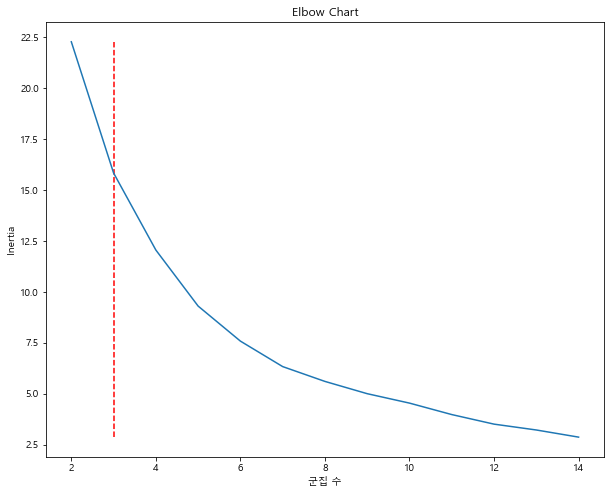

In [4]:
train_data = user_info_new[["mean_review_time_lag", "review_recency", "total_review_num"]].values

inertia_arr = []
k_range = range(2,15)

for k in k_range:
    
    kmeans = KMeans(n_clusters=k, random_state = 200)
    kmeans.fit(train_data)
    inertia_k = kmeans.inertia_
    
    inertia_arr.append(inertia_k)
    
## Elbow Chart 시각화

plt.figure(figsize = (10,8))

plt.plot(k_range, inertia_arr)
plt.vlines(3,ymin = np.array(inertia_arr).min(),ymax = np.array(inertia_arr).max() ,linestyle = '--', colors = 'r')

plt.title("Elbow Chart")
plt.xlabel("군집 수")
plt.ylabel("Inertia")

plt.show()

* Inertia 값이 가장 크게 감소하는 k=3을 기준으로 먼저 고객 세분화를 진행해본다

In [5]:
def get_clustering_result(k):
        
    ## model building
    model = KMeans(n_clusters=k, random_state = 200)
    model.fit(train_data)

    user_info_new["cluster"] = model.fit_predict(train_data)
    

    # Figure

    figure = plt.figure(figsize=(12, 10))
    ax = figure.add_subplot(projection="3d")
    ax.set_xlabel("평균 리뷰 작성 주기")
    ax.set_ylabel("총 작성 리뷰 수")
    ax.set_zlabel("최근 활동도")


    # Data and 3D scatter
    colors = ["red", "blue", "purple", "black", "pink"]

    sc = ax.scatter(user_info_new.mean_review_time_lag, user_info_new.total_review_num, user_info_new.review_recency,
                    alpha=0.6, c =user_info_new.cluster,marker="o")

    # Legend 1
    handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
    legend1 = ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc="upper center", title="고객 집단")
    ax.add_artist(legend1) # <- this is important.

    plt.show()

### 1-3. k=3 클러스터링

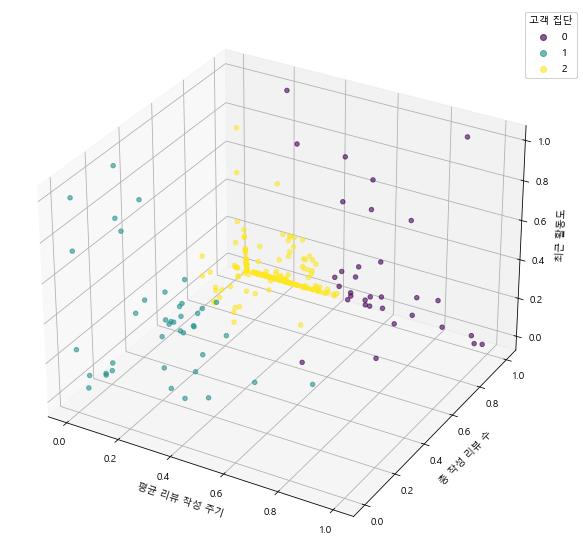

In [6]:
get_clustering_result(3)

* Elbow Chart를 통해 찾은 k=3 k-means clustering 결과이다. 

* 전체적인 데이터의 군집화는 잘 이뤄졌음

* 하지만 우리가 휴면 고객 집단을 찾아내어 푸시 이메일 마케팅을 하려고 하는 목적을 따져봤을 때, "최근 활동도" 변수의 측면에서 이질적인 두 집단을 잘 분리하지 못하는 것은 좋지않다. 

* 군집 수 (k) 값을 4,5 로 늘려가며 군집화 결과를 확인하며 우리의 의도와 맞는 군집화 결과가 나오는지 확인한다. 

### 1-4. k=4 클러스터링

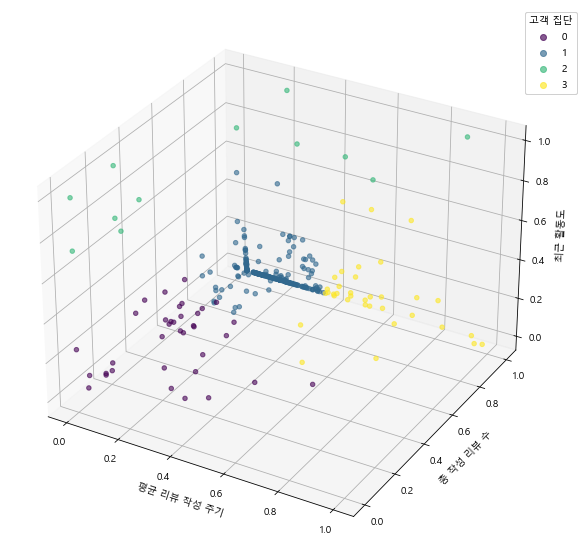

In [7]:
get_clustering_result(4)

* k=4 군집화 결과 역시, "최근 활동도" 변수에 따른 이질적인 집단을 분리해내지 못한다.

### 1-5. k = 5 클러스터링

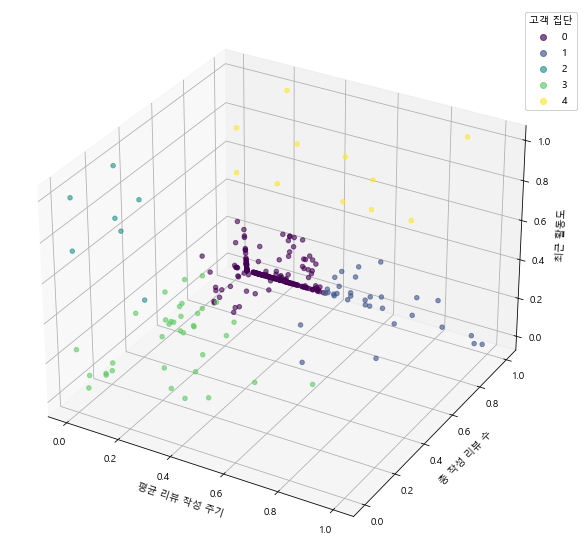

In [8]:
get_clustering_result(5)

* 최근 활동도 측면에서 이질적인 두 집단을 잘 분리 해냄과 동시에, 이외 2가지 파생변수 측면에서도 군집화 성능이 괜찮게 나왔다

## 2. 고객 집단 특성 파악

In [9]:
user_info = user_info.merge(user_info_new[["nickname", "cluster"]], on = "nickname")

In [10]:
user_info

,nickname,age,skin_type,gender,mean_review_time_lag,review_recency,total_review_num,cluster
0,기린91,59,건성,여,0.000000,0,10,3
1,포카리블루,30,민감성,여,7.632653,0,50,0
2,둘리대장,23,지성,여,11.775510,0,50,0
3,chick25,30,민감성,여,8.510204,0,50,0
4,2N,32,복합성,여,4.714286,0,50,0
...,...,...,...,...,...,...,...,...
316,판다s,21,복합성,여,2.066667,30,16,3
317,파카러부,30,복합성,여,10.346939,0,50,0
318,글로리#RL9NRZ,40,민감성,여,2.346939,5,50,0
319,고양이실패단_,25,중성,여,28.428571,30,50,1


In [11]:
def plot_hist_clusters(cluster):
    
    ## subplot 설정
    fig, (axes1, axes2) = plt.subplots(2,3, figsize = (8,8))

    ## 전체 집단 그래프
    sns.kdeplot(x = user_info.review_recency, ax= axes1[0])
    sns.kdeplot(x = user_info.mean_review_time_lag, ax= axes1[1])
    sns.kdeplot(x = user_info.total_review_num, ax= axes1[2])

    ## 고객 집단 그래프
    group = user_info.loc[user_info.cluster == cluster]

    sns.distplot(x = group.review_recency,bins = group.shape[0], kde=False, ax= axes2[0])
    sns.distplot(x = group.mean_review_time_lag,bins = group.shape[0],kde=False, ax= axes2[1])
    sns.distplot(x = group.total_review_num,bins = group.shape[0], kde=False, ax= axes2[2])

    axes2[0].set_xlim([-2,np.max(user_info.review_recency)])
    axes2[1].set_xlim([-2,np.max(user_info.mean_review_time_lag)])
    axes2[2].set_xlim([-2,np.max(user_info.total_review_num)])

    ## 축 제목 설정
    axes1[0].set_title("최근 활동도 (Recency)")
    axes1[1].set_title("평균 리뷰 작성 주기 (Frequency)")
    axes1[2].set_title("총 작성 리뷰 수 (Monetary)")

    axes1[0].set_xlabel("")
    axes1[1].set_xlabel("")
    axes1[2].set_xlabel("")
    
    axes1[0].set_ylabel("")
    axes1[1].set_ylabel("")
    axes1[2].set_ylabel("")
    
    
    plt.tight_layout()
    plt.show()

    
def get_RFM_summary(cluster):
    
    user_stat_df = user_info.loc[user_info.cluster == cluster]
    
    print("전체 유저 RFM Summary")
    
    print("""
    Recency 평균: %.2f
    Frequency 평균: %.2f
    Monetary 평균: %.2f
    """%(user_info.review_recency.mean(), user_info.mean_review_time_lag.mean(),user_info.total_review_num.mean()))
    
    
    print("%s번째 유저 집단 RFM Summary"%(cluster))
    
    print("""
    Recency 평균: %.2f
    Frequency 평균: %.2f
    Monetary 평균: %.2f   
    """%(user_stat_df.review_recency.mean(), user_stat_df.mean_review_time_lag.mean(),user_stat_df.total_review_num.mean()))

### 2-1. 0 번째 유저 그룹

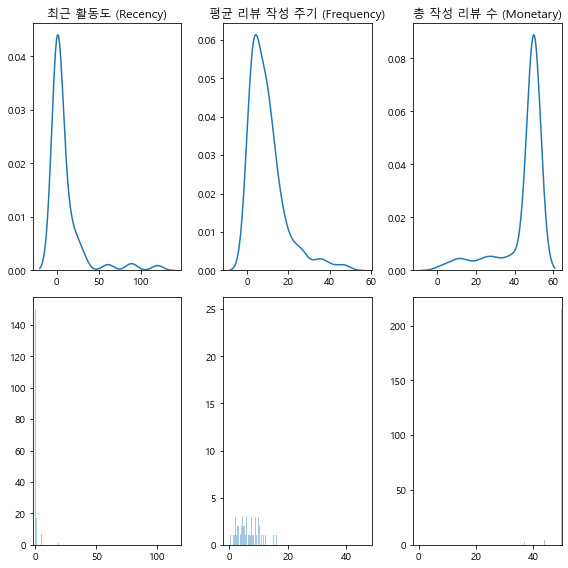

In [12]:
plot_hist_clusters(0)

In [13]:
get_RFM_summary(0)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
0번째 유저 집단 RFM Summary

    Recency 평균: 3.57
    Frequency 평균: 7.29
    Monetary 평균: 49.26   
    


0 번째 유저 그룹 특징 

* 휴면 기간이 전체 집단에 비해 상당히 긴 휴면 고객임

* 과거 활동 당시 매우 자주 리뷰를 올리기는 했으나 총 리뷰작성 수는 매우 적음

### 2-2. 1번째 유저 그룹

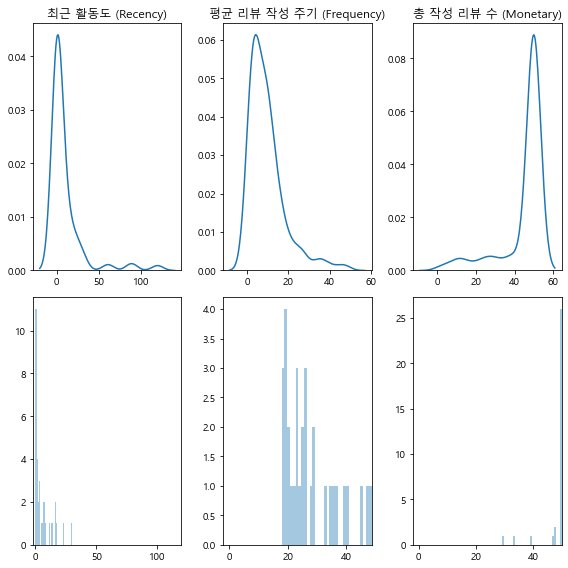

In [14]:
plot_hist_clusters(1)

In [15]:
get_RFM_summary(1)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
1번째 유저 집단 RFM Summary

    Recency 평균: 5.56
    Frequency 평균: 27.72
    Monetary 평균: 48.25   
    


1번째 유저 그룹

* 매우 최근 활동 이력이 있고, 매우 자주 많은 리뷰를 작성함 : 우수고객이라고 볼 수 있음

### 2-3. 2번째 유저 그룹

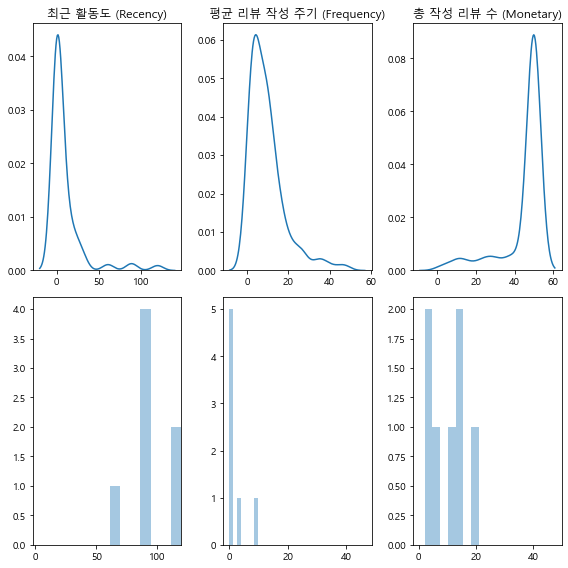

In [16]:
plot_hist_clusters(2)

In [17]:
get_RFM_summary(2)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
2번째 유저 집단 RFM Summary

    Recency 평균: 93.86
    Frequency 평균: 1.85
    Monetary 평균: 10.14   
    


2번 째 유저 집단

* 최근에 가입한 신규 유저, 짧은 주기를 가지고 활발히 활동함.

### 2-4. 3번째 유저 그룹

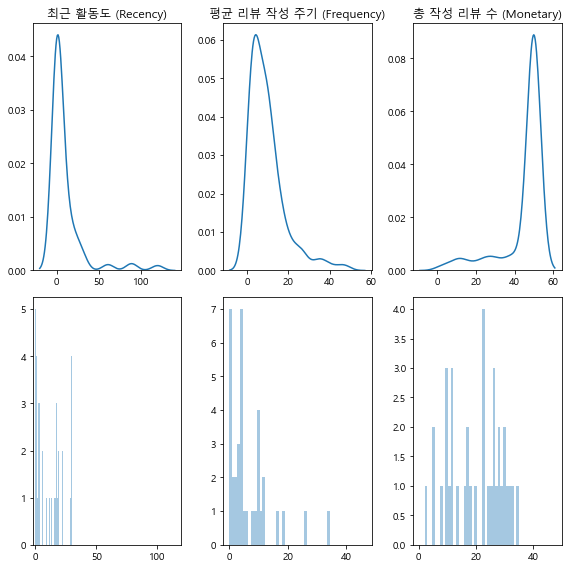

In [18]:
plot_hist_clusters(3)

In [19]:
get_RFM_summary(3)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
3번째 유저 집단 RFM Summary

    Recency 평균: 11.19
    Frequency 평균: 6.84
    Monetary 평균: 20.00   
    


3번 째 유저 그룹

* 비교적 리뷰 작성 주기가 전체 평균에 비해 김. 전체적인 누적 리뷰 작성글 수는 많은 걸로 보아 장기 가입 고객임을 유추 할 수 있음

### 2-5. 4번째 유저그룹

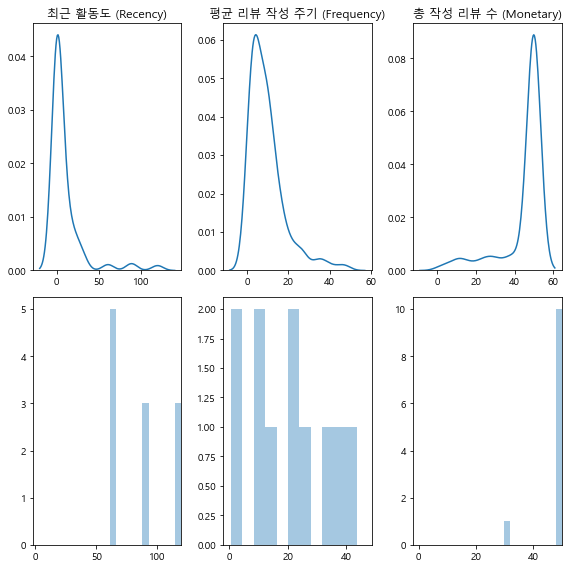

In [20]:
plot_hist_clusters(4)

In [21]:
get_RFM_summary(4)

전체 유저 RFM Summary

    Recency 평균: 9.38
    Frequency 평균: 9.58
    Monetary 평균: 44.99
    
4번째 유저 집단 RFM Summary

    Recency 평균: 84.73
    Frequency 평균: 19.69
    Monetary 평균: 48.18   
    


4번 째 유저 그룹

* 상당히 장기간 활동이 없는 유저 그룹

* 평균 적인 리뷰 작성 주기도 3주정도

* 누적 리뷰 작성 수를 보았을 때 오래전에 가입을 하여 활동 기간은 오래된 것으로 보임


In [22]:
## 각 군집별 유저 비율 (%)

user_info.groupby("cluster").count().review_recency/user_info.shape[0]*100

cluster
0    73.208723
1     9.968847
2     2.180685
3    11.214953
4     3.426791
Name: review_recency, dtype: float64